## Background

This notebook shows how to use SageMaker Notebook for data pre-processing steps like ingestion, cleaning and processing and feature engineering for a car prediction project.

In [1]:
! pip install sagemaker botocore boto3 awscli matplotlib seaborn pandas --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.2/892.2 kB 29.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for botocore from https://files.pythonhosted.org/packages/1d/48/6c1118ac9168fcb49900a6a1aefb6d70f44da1da689c498293d133a5f5f1/botocore-1.31.57-py3-none-any.whl.metadata
  Obtaining dependency information for boto3 from https://files.pythonhosted.org/packages/91/a9/c6eea6c80c57d8957eaba3cc1122339a1adbdce60532cbf94046c312bcd3/boto3-1.28.57-py3-none-any.whl.metadata
  Obtaining dependency information for awscli from https://files.pythonhosted.org/packages/d3/ef/f3696e2e9dc04077e4d50ce4ad3c237aca5d0068a999cad7da02b129bc43/awscli-1.29.57-py3-none-any.whl.metadata
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/b5/24/aaccf324ce862bb82277e8814d2aebbb2a2c160d04e95aa2b8c9dc3137a9/matplotlib-3.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency informati

In [2]:
import sagemaker
import json
import pandas as pd
import numpy as np
import boto3

import matplotlib.pyplot as plt
#!python -m pip install --upgrade pip
#!pip install -q 's3fs' 'sagemaker-experiments'
#!pip install --upgrade sagemaker boto3

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Upload the "car_prediction_data.csv" csv file to a bucket in your account and load it into this notebook instance.

The following cell, lists configurable parameters to interact with the S3 and Sagemaker.

In [57]:
sagemaker_session = sagemaker.Session()
s3 = sagemaker_session.boto_session.resource("s3")

region = boto3.Session().region_name
role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [84]:
!aws s3 cp s3://day05-humber/car_prediction_data.csv .

download: s3://day05-humber/car_prediction_data.csv to ./car_prediction_data.csv


In [85]:
df=pd.read_csv('car_prediction_data.csv')

In [86]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [87]:
df.shape

(301, 9)

Let's check how many values we have in the categorical columns:

In [88]:
print(df['Seller_Type'].unique())
print(df['Fuel_Type'].unique())
print(df['Transmission'].unique())
print(df['Owner'].unique())

['Dealer' 'Individual']
['Petrol' 'Diesel' 'CNG']
['Manual' 'Automatic']
[0 1 3]


Check if there is any null value present:

In [89]:
df.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

Let's get some statistics about the numerical values:

In [90]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


Now we create a new data set out of the existing data set by removing the car name. The name of the car should not be an indicator for price prediction:

In [91]:
final_dataset=df[['Year','Selling_Price','Present_Price','Kms_Driven','Fuel_Type','Seller_Type','Transmission','Owner']]

Let's check if we drop that column or not:

In [92]:
final_dataset.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


Something that is missing in this data set is the age of car as it would surely change the price of the car. Let's add the required columns:

In [93]:
final_dataset['Current_Year']=2022

In [94]:
final_dataset.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Current_Year
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,2022
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,2022
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,2022
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,2022
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,2022


In [95]:
final_dataset['car_age']=final_dataset['Current_Year']- final_dataset['Year']

In [96]:
final_dataset.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Current_Year,car_age
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,2022,8
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,2022,9
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,2022,5
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,2022,11
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,2022,8


Now that we have added the car age, we do not need the "year" column:

In [97]:
final_dataset.drop(['Year'],axis=1,inplace=True)

In [98]:
final_dataset.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Current_Year,car_age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,2022,8
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,2022,9
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,2022,5
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,2022,11
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,2022,8


In [99]:
final_dataset.shape

(301, 9)

Now we need to convert the categorical data into numerical data by one hot encoding:

In [100]:
final_dataset=pd.get_dummies(final_dataset,drop_first=True)

In [101]:
final_dataset.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Current_Year,car_age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,2022,8,False,True,False,True
1,4.75,9.54,43000,0,2022,9,True,False,False,True
2,7.25,9.85,6900,0,2022,5,False,True,False,True
3,2.85,4.15,5200,0,2022,11,False,True,False,True
4,4.60,6.87,42450,0,2022,8,True,False,False,True


Please consider that during one hot encoding we try to drop a few columns to save processing time. For example we have only Seller_Type_Individual and not Seller_Type_Dealer since if that is not 1, the other is implied.

We also have calculated the car_age, so we do not need the current age anymore:

In [76]:
final_dataset=final_dataset.drop(['Current_Year'],axis=1)

In [77]:
final_dataset.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,car_age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,8,False,True,False,True
1,4.75,9.54,43000,0,9,True,False,False,True
2,7.25,9.85,6900,0,5,False,True,False,True
3,2.85,4.15,5200,0,11,False,True,False,True
4,4.60,6.87,42450,0,8,True,False,False,True


Now let's find the correlation between features in our data set:

In [102]:
final_dataset.corr()

,Selling_Price,Present_Price,Kms_Driven,Owner,Current_Year,car_age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
Selling_Price,1.000000,0.878983,0.029187,-0.088344,NaN,-0.236141,0.552339,-0.540571,-0.550724,-0.367128
Present_Price,0.878983,1.000000,0.203647,0.008057,NaN,0.047584,0.473306,-0.465244,-0.512030,-0.348715
Kms_Driven,0.029187,0.203647,1.000000,0.089216,NaN,0.524342,0.172515,-0.172874,-0.101419,-0.162510
Owner,-0.088344,0.008057,0.089216,1.000000,NaN,0.182104,-0.053469,0.055687,0.124269,-0.050316
Current_Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
car_age,-0.236141,0.047584,0.524342,0.182104,NaN,1.000000,-0.064315,0.059959,0.039896,-0.000394
Fuel_Type_Diesel,0.552339,0.473306,0.172515,-0.053469,NaN,-0.064315,1.000000,-0.979648,-0.350467,-0.098643
Fuel_Type_Petrol,-0.540571,-0.465244,-0.172874,0.055687,NaN,0.059959,-0.979648,1.000000,0.358321,0.091013
Seller_Type_Individual,-0.550724,-0.512030,-0.101419,0.124269,NaN,0.039896,-0.350467,0.358321,1.000000,0.063240
Transmission_Manual,-0.367128,-0.348715,-0.162510,-0.050316,NaN,-0.000394,-0.098643,0.091013,0.063240,1.000000


Let's visualize the correleation matrix:

In [103]:
import seaborn as sns

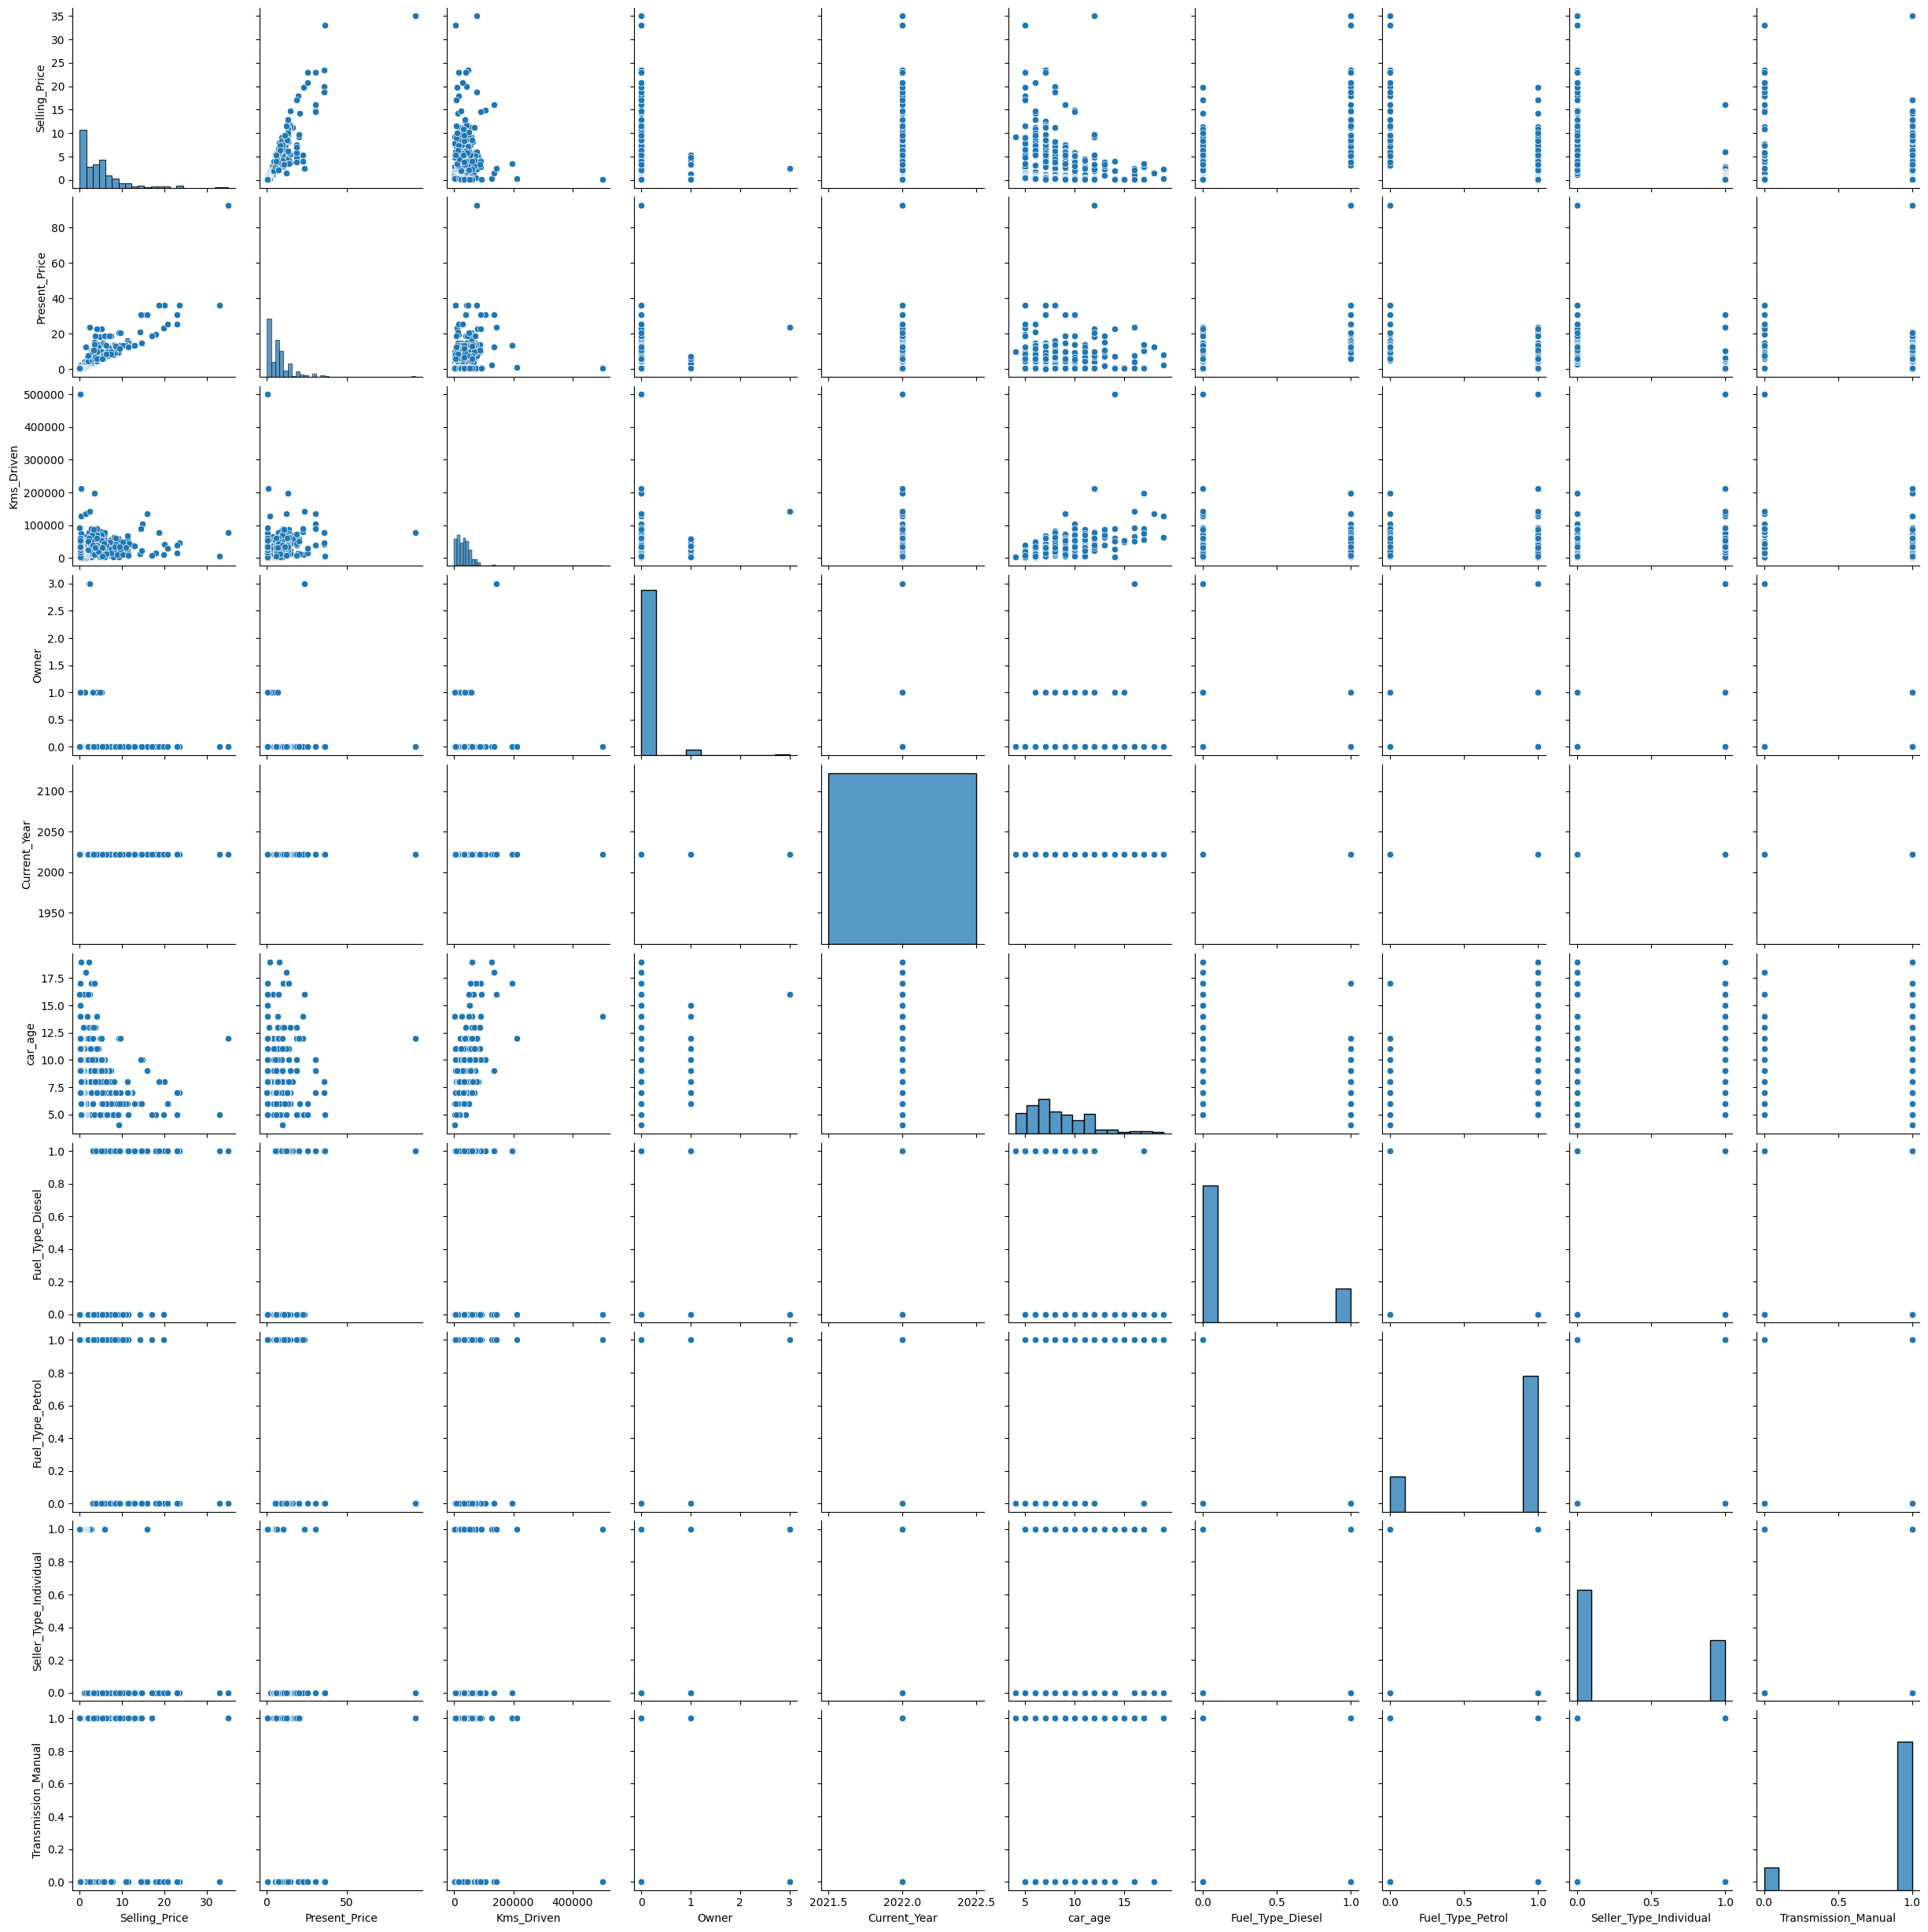

In [104]:
sns.pairplot(final_dataset)

Now we can create the heatmap:

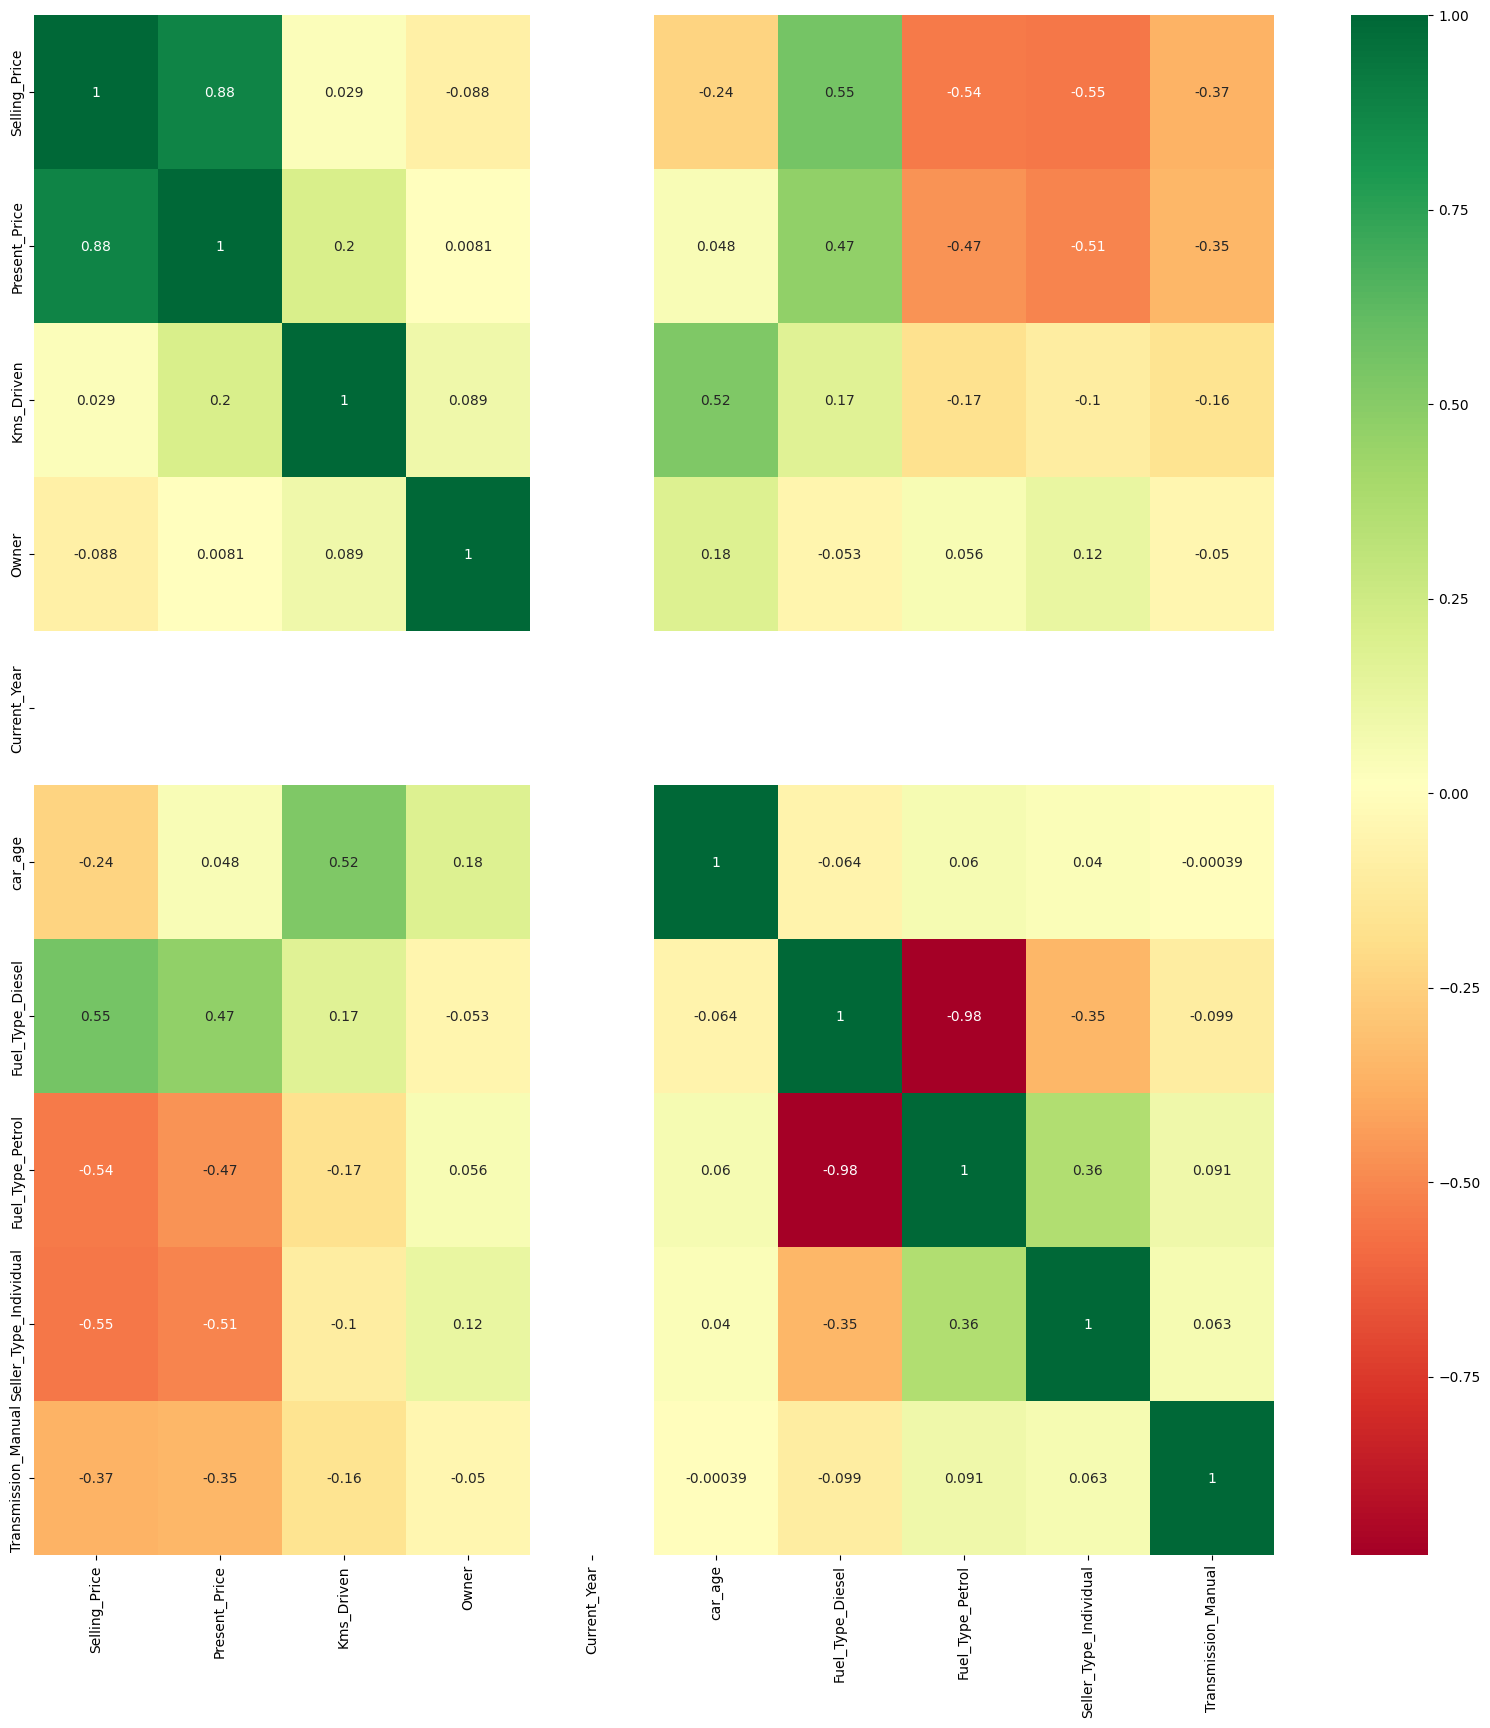

In [107]:
import seaborn as sns

corrmat = final_dataset.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

g=sns.heatmap(final_dataset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Now it's time to seperat the independant columns from the dependant column. In the following cell, X = final_dataset.iloc[:, 1:] means selecting <b>all rows (since : is specified before the comma) and all columns starting from index 1 to the end (all columns excluding the column at index 0)</b>, and assigning this subset to the variable X. Essentially, this means X will contain all columns of final_dataset except the first one. On the other hand, y = final_dataset.iloc[:, 0] means selecting all rows and only the column at index 0 from final_dataset, and assigning this subset to the variable y. So, y will contain only the first column of final_dataset.

In [108]:
X=final_dataset.iloc[:,1:]
y=final_dataset.iloc[:,0]

The label column (dependant column) is the "selling price" and we remove it from the X matrix

In [109]:
X.head()

,Present_Price,Kms_Driven,Owner,Current_Year,car_age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,5.59,27000,0,2022,8,False,True,False,True
1,9.54,43000,0,2022,9,True,False,False,True
2,9.85,6900,0,2022,5,False,True,False,True
3,4.15,5200,0,2022,11,False,True,False,True
4,6.87,42450,0,2022,8,True,False,False,True


While Y has only "selling price": 

In [110]:
y.head()

0    3.35
1    4.75
2    7.25
3    2.85
4    4.60
Name: Selling_Price, dtype: float64

### Feature Importance

Sometimes we have many columns and we want remove a few of them to make the learning faster but we do not know which columns are more important than others. 

Fortuantly sklearn has a quick way to generate that report for us. We do that by using <b>ExtraTreesRegressor</b> model from Scikit-Learn's ensemble module. Extra Trees stands for extremely randomized trees, which is a tree-based ensemble method, usually used for regression and classification tasks. It is similar to Random Forest but it builds trees differently.

In the following lines, we create an instance of the ExtraTreesRegressor class and assigning it to the variable model. Then we fit (train) the model on the feature matrix X and target variable y.

In [111]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

Once the model is fitted, you can use it to make predictions on unseen data, evaluate its performance, and inspect the feature importances (that is what we do below). After running the following line, it prints out an array representing the importance of each feature used to train the ExtraTreesRegressor model. These importance values are computed based on the amount each feature contributes to improving the model’s performance, such as reducing the error in regression models.

In [112]:
print(model.feature_importances_)

[0.39785171 0.03889783 0.0012529  0.         0.08198577 0.20993226
 0.01323904 0.12771769 0.1291228 ]


Each value in the array corresponds to a feature in your X dataset, in the order they are presented. Based on the above matrix we can see the first (0.39785171) and the fifth (0.21702262) columns are the most important ones. A value of <b>0</b> means that the corresponding feature was not used at all by the model to make predictions, implying it has no importance according to the model.


Now let's sort the 5 most important features. I use <b>pd.Series(data, index=index)</b> to create pandas Series object where data the array of feature impirtance, and index is X columns.

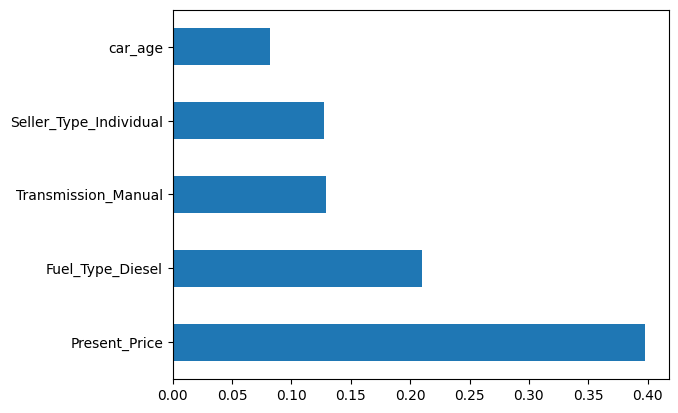

In [114]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

## Assignment

Split the data set to two sets, training and test sets. Upload the data sets to S3 bucket, one in the "train" folder and the other one in the "test" folder. Make sure the training data has X and Y together while the test X is not with Y test